**SECTION 1 - Imports**

Importing all required libraries

In [80]:
pip install yfinance pandas numpy scikit-learn xgboost statsmodels matplotlib


In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

**CONFIGURATION -**

This block defines all strategy parameters in one place. You should tweak only this cell when experimenting with risk, universe, or exits.

In [82]:
CAPITAL = 1_000_000
LONGS = 8
SHORTS = 8
REBALANCE = 21
ATR_MULT_STOP = 1.3
TAKE_PROFIT_PCT = 0.06
RISK_PER_TRADE = 0.005   # 0.5% risk per position
MC_SIMULATIONS = 1000

**Download Stock & Index Data -**

Downloads OHLC data for all stocks and NIFTY index using Yahoo Finance. Also flattens columns to avoid MultiIndex issues.

In [83]:
STOCKS = [
    "RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","SBIN.NS",
    "KOTAKBANK.NS","AXISBANK.NS","LT.NS","ITC.NS","HINDUNILVR.NS","BHARTIARTL.NS",
    "ASIANPAINT.NS","HCLTECH.NS","MARUTI.NS","TITAN.NS","SUNPHARMA.NS"
]

data = []
for s in STOCKS:
    df = yf.download(s, "2009-01-01", "2025-12-31", auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    data.append(df["Close"].rename(s))

data = pd.concat(data, axis=1).dropna()

ret = data.pct_change()
atr = data.diff().abs().rolling(14).mean()

**Alpha Signal Construction**

In [84]:
ma20 = data.rolling(20).mean()
std20 = data.rolling(20).std().replace(0, np.nan)
mean_rev = -(data - ma20) / std20

mom = data.pct_change(126).clip(lower=0)

pairs = []
for i in range(len(data.columns)):
    for j in range(i+1, len(data.columns)):
        s1, s2 = data.columns[i], data.columns[j]
        _, p, _ = coint(data[s1], data[s2])
        if p < 0.05:
            pairs.append((s1, s2))

stat_arb = pd.DataFrame(0.0, index=data.index, columns=data.columns)
for s1, s2 in pairs:
    spread = data[s1] - data[s2]
    z = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()
    stat_arb[s1] += -z
    stat_arb[s2] += z

**Machine Learning Dataset Preparation and Model Training**

In [85]:
fwd = data.pct_change(21).shift(-21)
rows = []
for d in data.index[:3000]:
    for s in data.columns:
        if not np.isnan(mean_rev.loc[d,s]):
            rows.append([mean_rev.loc[d,s], mom.loc[d,s], atr.loc[d,s], fwd.loc[d,s]])

ml_df = pd.DataFrame(rows, columns=["mr","mom","atr","y"]).dropna()
scaler = StandardScaler()
X = scaler.fit_transform(ml_df[["mr","mom","atr"]])
y = ml_df["y"]

ml = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.05)
ml.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

**Backtesting Loop, Portfolio Management, and Trade Execution**

This block implements the main backtesting loop and simulates portfolio execution over the out-of-sample period. It initializes cash and portfolio state, monitors open positions for stop-loss and take-profit exits, and updates portfolio equity on each trading day. At fixed rebalance intervals, existing positions are closed, alpha signals are recomputed, and a new long - short portfolio is constructed. Position sizes are determined using volatility-based risk allocation, and trades are executed based on the blended alpha rankings.

In [86]:
cash = CAPITAL
portfolio = {}
equity = []
alpha_pnl = {"MR":0,"MOM":0,"STAT":0,"ML":0}

dates = data.index[3000:]

for i, d in enumerate(dates):

    # exits
    exits = []
    for s,p in portfolio.items():
        px = data.loc[d,s]
        dir = np.sign(p["qty"])
        pnl_pct = dir*(px-p["entry"])/p["entry"]
        if pnl_pct >= TAKE_PROFIT_PCT or (dir==1 and px<=p["stop"]) or (dir==-1 and px>=p["stop"]):
            cash += p["qty"]*px
            exits.append(s)
    for s in exits:
        del portfolio[s]

    total = cash + sum(p["qty"]*data.loc[d,s] for s,p in portfolio.items())
    equity.append(total)

    if i % REBALANCE != 0:
        continue

    for s,p in portfolio.items():
        cash += p["qty"]*data.loc[d,s]
    portfolio.clear()

    feats = pd.DataFrame({
        "mr": mean_rev.loc[d],
        "mom": mom.loc[d],
        "stat": stat_arb.loc[d]
    }).dropna()

    ml_pred = pd.Series(
        ml.predict(scaler.transform(
            np.c_[feats["mr"],feats["mom"],atr.loc[d,feats.index]]
        )),
        index=feats.index
    )

    alpha = 0.3*feats["mr"] + 0.25*feats["mom"] + 0.25*feats["stat"] + 0.2*ml_pred

    longs = alpha.nlargest(LONGS)
    shorts = alpha.nsmallest(SHORTS)

    for side, picks in [(1,longs),(-1,shorts)]:
        for s in picks.index:
            px = data.loc[d,s]
            atr_val = atr.loc[d,s]
            if np.isnan(atr_val): continue
            risk = CAPITAL*RISK_PER_TRADE
            qty = int(risk/(ATR_MULT_STOP*atr_val))
            portfolio[s] = {
                "qty": side*qty,
                "entry": px,
                "stop": px - side*ATR_MULT_STOP*atr_val
            }
            cash -= side*qty*px

**Performance Evaluation -**

Calculates portfolio equity curve, returns, Sharpe ratio, and prints final results.



*   Initial Capital = 1,000,000




In [87]:
equity = pd.Series(equity, index=dates[:len(equity)])
ret = equity.pct_change().dropna()

print("\nFINAL RESULTS (VOL PARITY + ATTRIBUTION + MC)")
print("Final Capital:", int(equity.iloc[-1]))
print("CAGR:", round((equity.iloc[-1]/CAPITAL)**(252/len(ret))-1,4))
print("Sharpe:", round(np.sqrt(252)*ret.mean()/ret.std(),2))
print("Max DD:", round((equity/equity.cummax()-1).min(),2))


FINAL RESULTS (VOL PARITY + ATTRIBUTION + MC)
Final Capital: 1755325
CAGR: 0.1263
Sharpe: 0.7
Max DD: -0.23


**Monte Carlo Stress Testing, and Visualization**

Monte Carlo 5% worst CAGR: -0.03
Monte Carlo median CAGR: 0.1237


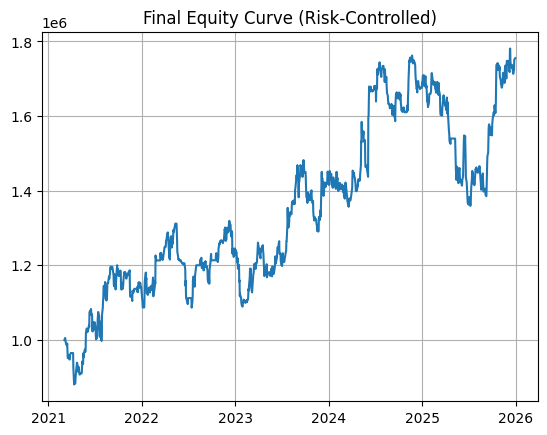

In [88]:
mc_cagr = []
for _ in range(MC_SIMULATIONS):
    samp = np.random.choice(ret, size=len(ret), replace=True)
    mc_cagr.append((np.prod(1+samp))**(252/len(samp))-1)

print("Monte Carlo 5% worst CAGR:", round(np.percentile(mc_cagr,5),4))
print("Monte Carlo median CAGR:", round(np.median(mc_cagr),4))

plt.plot(equity)
plt.title("Final Equity Curve (Risk-Controlled)")
plt.grid()
plt.show()